In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import (
    StandardScaler, label_binarize, PolynomialFeatures,
    RobustScaler, robust_scale, quantile_transform, QuantileTransformer)
from sklearn.compose import make_column_selector, ColumnTransformer
from scipy.stats.mstats import winsorize
from sklearn.calibration import CalibratedClassifierCV
import xgboost
from joblib import dump, load
np.random.seed(0)  # make sure results are reproducible

In [2]:
%env PATH=/home/jdkent/.conda/envs/comfy_pants/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin


env: PATH=/home/jdkent/.conda/envs/comfy_pants/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/conda/bin


In [3]:
TRAINING_DATA_PATH = '../data/BipolarDerivedDataTraining.csv'
TESTING_DATA_PATH = '../data/BipolarDerivedDataTesting.csv'
NTHREADS = 32

In [4]:
training_X = pd.read_csv(TRAINING_DATA_PATH)
training_y = label_binarize(pd.read_csv(TRAINING_DATA_PATH)['group'], classes=["Case", "Control"]).squeeze()
testing_X = pd.read_csv(TESTING_DATA_PATH)

In [5]:
missing_cols = [
    'ses_ladder_rung',
    'history_smoking', 'frequency_currentsmoking',
    'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
    'suicideideation_rating_mostsevere_life',
    'suicideideation_rating_mostsevere_1month',
    'suicideattempts_lifetimenumber'
]
missing_cols.reverse()
for col in missing_cols:
    testing_X.insert(4, col, ["NOT REAL"] * testing_X.shape[0])
testing_X.insert(1, "group", ["NOT REAL"] * testing_X.shape[0])
testing_X.rename(columns={"Age": "age", "Sex": "gender", 'Hand': 'handedness'}, inplace=True)

In [6]:
set(training_X.columns) - set(testing_X.columns)

set()

In [7]:
training_X.columns[:17]

Index(['record_id', 'group', 'age', 'gender', 'handedness', 'ses_ladder_rung',
       'history_smoking', 'frequency_currentsmoking',
       'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
       'suicideideation_rating_mostsevere_life',
       'suicideideation_rating_mostsevere_1month',
       'suicideattempts_lifetimenumber', 'allvol_unknown',
       'allvol_ctx_rh_posterior_insula', 'allvol_ctx_lh_posterior_insula'],
      dtype='object')

In [8]:
testing_X.columns[:17]

Index(['record_id', 'group', 'age', 'gender', 'handedness', 'ses_ladder_rung',
       'history_smoking', 'frequency_currentsmoking',
       'age_at_first_mood_syndrome', 'madrs_score', 'ymrs_score',
       'suicideideation_rating_mostsevere_life',
       'suicideideation_rating_mostsevere_1month',
       'suicideattempts_lifetimenumber', 'allvol_unknown',
       'allvol_ctx_rh_posterior_insula', 'allvol_ctx_lh_posterior_insula'],
      dtype='object')

## Model 1 (XGBoost with feature selection)

In [9]:
# supposedly ideal "scale_pos_weight"
best_spw = (training_y == 0).sum() / training_y.sum()
best_spw

1.8387096774193548

In [10]:
np.random.seed(0) 
MODEL1 = '../models/model1-jdkent.joblib'
OVERWRITE_MODEL1 = False
if not os.path.isfile(MODEL1) or OVERWRITE_MODEL1:
    os.remove(MODEL1)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    select_pca = SelectKBest(k=5)
    clf = xgboost.XGBClassifier(
        n_estimators=2500, subsample=0.8, learning_rate=0.001,
        max_depth=5, scale_pos_weight=3)


    pipeline1 = Pipeline([("data", select_data),
                          ("outlier", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("select", select_pca),
                          ("clf", clf)])
    pipeline1.fit(training_X, training_y)
    # write model to file
    dump(pipeline1, MODEL1)
else:
    pipeline1 = load(MODEL1)

prediction1 = pipeline1.predict(testing_X)
pipeline1_proba = pipeline1.predict_proba(testing_X)
dump(pipeline1_proba, '../models/jdkent-pipeline1_proba.pkl')
prediction1

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1])

In [11]:
# intuition on whether the model is split approx 50/50
display((prediction1 == 1).sum())
display((prediction1 == 0).sum())

20

19

## Model 2 (Logistic Regression with feature selection)

In [12]:
np.random.seed(0)
MODEL2 = '../models/model2-jdkent.joblib'
OVERWRITE_MODEL2 = False
if not os.path.isfile(MODEL2) or OVERWRITE_MODEL2:
    os.remove(MODEL2)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    selector = LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, random_state=42, max_iter=10000)

    rfe = RFE(selector, n_features_to_select=10)

    clf = LogisticRegression(C=1000, class_weight={0: 1, 1: 3}, random_state=42, max_iter=10000)

    pipeline2 = Pipeline([("data", select_data),
                          ("outliers", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("rfe", rfe),
                          ("clf", clf)])
    pipeline2.fit(training_X, training_y)
    # write model to file
    dump(pipeline2, MODEL2)
else:
    pipeline2 = load(MODEL2)

prediction2 = pipeline2.predict(testing_X)
pipeline2_proba = pipeline2.predict_proba(testing_X)
dump(pipeline2_proba, '../models/jdkent-pipeline2_proba.pkl')
prediction2

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])

In [13]:
display((prediction2 == 1).sum())
display((prediction2 == 0).sum())

20

19

In [103]:
average_prob = np.average(np.array([pipeline1_proba, pipeline2_proba]), axis=0)
y_best_guess = np.argmax(average_prob, axis=1)
y_best_guess

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0])

## Model MADRS

In [17]:
np.random.seed(0) 
MODEL_MADRS = '../models/modelMADRS-jdkent.joblib'
OVERWRITE_MADRS = False
if not os.path.isfile(MODEL_MADRS) or OVERWRITE_MADRS:
    if os.path.isfile(MODEL_MADRS):
        os.remove(MODEL_MADRS)
    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    select_pca = SelectKBest(k=5)
    clf = xgboost.XGBRegressor(
        reg_alpha=1, reg_lambda=2, learning_rate=0.5,
        n_estimators=2500, subsample=0.8,
        max_delta_step=3,
        min_child_weight=3,
        max_depth=10)


    pipelineMADRS = Pipeline([("data", select_data),
                          ("outlier", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("select", select_pca),
                          ("clf", clf)])
    pipelineMADRS.fit(training_X, training_y)
    # write model to file
    dump(pipelineMADRS, MODEL_MADRS)
else:
    pipelineMADRS = load(MODEL_MADRS)

predictionMADRS = pipelineMADRS.predict(testing_X)
dump(predictionMADRS, '../models/jdkent-madrs_prediction.pkl')
predictionMADRS

array([ 4.5248866e-02,  1.5969428e-01,  3.7886241e-01,  8.4301662e-01,
        5.2734655e-01,  2.9328325e-01,  3.6566171e-01,  7.6556063e-01,
        1.3247013e-02,  6.3023424e-01, -3.7425220e-02,  8.5134614e-01,
        5.6014508e-01,  1.5713245e-01,  9.9610817e-01,  1.8900171e-01,
        9.2004049e-01,  1.0244615e+00, -1.6624033e-02,  2.8543013e-01,
        9.5460069e-01,  4.9157786e-01, -1.4388442e-01,  1.9337356e-02,
        6.0282862e-01,  8.3093917e-01,  7.4624741e-01, -7.9428911e-02,
       -1.8881977e-02,  1.8760228e-01,  8.3677101e-01,  4.5528781e-01,
        2.7495798e-01,  2.7239960e-01, -1.0530949e-03,  2.5159723e-01,
        1.1073875e+00,  9.8263025e-01,  7.7408165e-01], dtype=float32)

## Model YMRS

In [18]:
np.random.seed(0) 
MODEL_YMRS = '../models/modelYMRS-jdkent.joblib'
OVERWRITE_YMRS = False
if not os.path.isfile(MODEL_YMRS) or OVERWRITE_YMRS:
    if os.path.isfile(MODEL_YMRS):
        os.remove(MODEL_YMRS)

    select_data = ColumnTransformer(
        [(
            "select_features",
            "passthrough", 
            make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
        remainder='drop'
    )

    fix_outliers = QuantileTransformer(output_distribution='normal')

    imputer = IterativeImputer(add_indicator=False,
                               initial_strategy='median',
                               imputation_order='random',
                               sample_posterior=True,
                               max_iter=50,
                               n_nearest_features=50,
                               random_state=42)

    scaler = StandardScaler()
    kbest = SelectKBest(k=1000)
    pca = PCA(n_components=40, whiten=True)
    select_pca = SelectKBest(k=5)
    clf = xgboost.XGBRegressor(
        reg_alpha=1, reg_lambda=2, learning_rate=0.5,
        n_estimators=2500, subsample=0.8,
        max_delta_step=3,
        min_child_weight=3,
        max_depth=10)


    pipelineYMRS = Pipeline([("data", select_data),
                          ("outlier", fix_outliers),
                          ("imp", imputer),
                          ("scaler", scaler),
                          ("kbest", kbest),
                          ("pca", pca),
                          ("select", select_pca),
                          ("clf", clf)])
    pipelineYMRS.fit(training_X, training_y)
    # write model to file
    dump(pipelineYMRS, MODEL_YMRS)
else:
    pipelineYMRS = load(MODEL_YMRS)

predictionYMRS = pipelineMADRS.predict(testing_X)
dump(predictionYMRS, '../models/jdkent-ymrs_prediction.pkl')
predictionYMRS

/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/xgboost/core.py:382: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([ 1.3184732e-01,  1.5969428e-01,  3.7886241e-01,  8.4301662e-01,
        5.2734655e-01,  2.9328325e-01,  3.6566171e-01,  6.3280439e-01,
        1.3247013e-02,  6.3023424e-01, -3.7425220e-02,  8.5173583e-01,
        5.6014508e-01,  1.5713245e-01,  9.9610817e-01,  1.8900171e-01,
        9.2004049e-01,  1.0508599e+00,  5.8411360e-03,  2.8543013e-01,
        9.5460069e-01,  1.1280762e+00, -9.7481966e-02,  1.9337356e-02,
        6.0282862e-01,  8.3093917e-01,  7.4624741e-01, -7.9428911e-02,
       -1.8881977e-02,  1.8760228e-01,  8.3677101e-01,  4.5528781e-01,
        2.7495798e-01,  2.7239960e-01, -1.0530949e-03,  2.5159723e-01,
        1.1073875e+00,  9.8263025e-01,  5.6600362e-01], dtype=float32)

## Investigate data dimensionality

In [19]:
select_data = ColumnTransformer(
    [(
        "select_features",
        "passthrough", 
        make_column_selector(pattern="31p.*[^r]$|t1r.*_m|alff.*_m|allvol|dti"))],
    remainder='drop'
)

fix_outliers = QuantileTransformer(output_distribution='normal')

imputer = IterativeImputer(add_indicator=False,
                           initial_strategy='median',
                           imputation_order='random',
                           sample_posterior=True,
                           max_iter=10,
                           n_nearest_features=50,
                           random_state=42)

scaler = StandardScaler()
kbest = SelectKBest(k=1000)
pca = PCA()

pipeline_pca = Pipeline([("data", select_data),
                      ("outliers", fix_outliers),
                      ("imp", imputer),
                      ("scaler", scaler),
                      ("kbest", kbest),
                      ("pca", pca)])

pca_res = pipeline_pca.fit_transform(training_X, training_y)


/home/jdkent/.conda/envs/comfy_pants/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [20]:
pca_keep = pca_res[:,:-1]

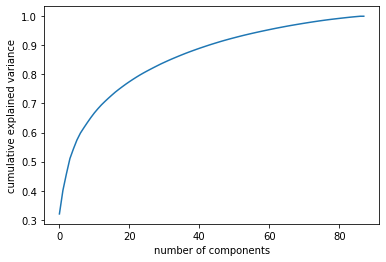

In [21]:
plt.plot(np.cumsum(pipeline_pca.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [22]:
kbest_pca = SelectKBest(k="all")
kbest_pca.fit(pca_keep, training_y)

SelectKBest(k='all', score_func=<function f_classif at 0x7fbe19057e60>)

<BarContainer object of 87 artists>

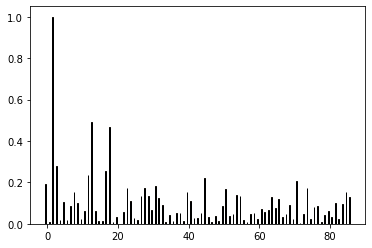

In [23]:
# indices
X_indices = np.arange(pca_keep.shape[-1] )
scores = -np.log10(kbest_pca.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

In [24]:
# get the two best components
kbest_pca.k = 2
best_components = kbest_pca.fit_transform(pca_keep, training_y)

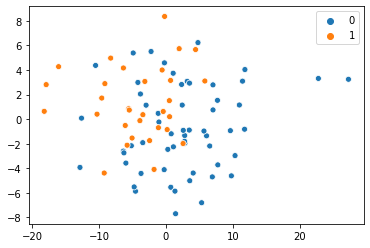

In [25]:
sns.scatterplot(x=best_components[:,0], y=best_components[:,1], hue=training_y)

In [26]:
indices = kbest_pca.get_support(indices=True)

In [27]:
loadings = pipeline_pca.named_steps['pca'].components_[indices,:]

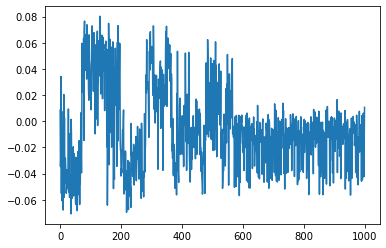

In [28]:
sns.lineplot(x=np.arange(loadings.shape[1]), y=loadings[0,:])

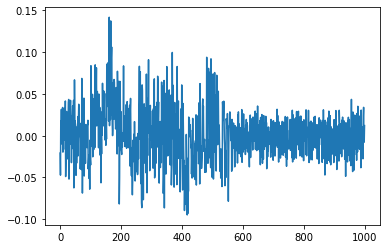

In [29]:
sns.lineplot(x=np.arange(loadings.shape[1]), y=loadings[1,:])

In [30]:
dset_idxs = pipeline_pca.named_steps['kbest'].get_support(indices=True)
columns = training_X.columns[dset_idxs]

In [31]:
# grab top 10 features loaded
comp0_top = np.argpartition(np.abs(loadings[0,:]), -15)[-10:]
# organize the features
comp0_top = comp0_top[np.argsort(np.abs(loadings[0,:])[comp0_top])]

In [32]:
# grab top 10 features loaded
comp1_top = np.argpartition(np.abs(loadings[1,:]), -15)[-10:]
# organize the features
comp1_top = comp1_top[np.argsort(np.abs(loadings[1,:])[comp1_top])]

In [33]:
columns[comp0_top]

Index(['t1r_ctxrcdlantcing_nv', 'allvol_wm_rh_parsopercularis',
       'alff_suspicious_m', 't1r_r_unsegmentedwm_m', 'lobevol_ctx_rh_frontal',
       't1r_cc_mid_post_nv', 'lobevol_left_putamen', 't1r_4thvent_nv',
       'allvol_left_orifg', 'lobevol_ctx_lh_temporal'],
      dtype='object')

In [34]:
columns[comp1_top]

Index(['t1r_wmrrostmidfrnt_m', 'dti_l_infcrblped_fa', 't1r_l_chorplex_nv',
       'alff_wmlparhipp_nv', 'alff_wmrins_m', 'alff_wmllingual_m',
       'alff_ctxlparsoper_m', 't1r_r_latvent_m', 't1r_csf_nv',
       't1r_l_hippo_m'],
      dtype='object')

## Investigate Model2

### Select Data

In [35]:
x_features = training_X.loc[:,pipeline2.named_steps['data'].transformers_[0][2]]
x_features.shape

(88, 1770)

### Fix Outliers

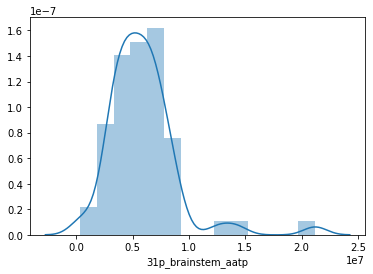

In [36]:
sns.distplot(x_features['31p_brainstem_aatp'])
col_idx = x_features.columns.get_loc('31p_brainstem_aatp')

In [37]:
x_features_quantrans = pipeline2.named_steps['outliers'].transform(x_features)

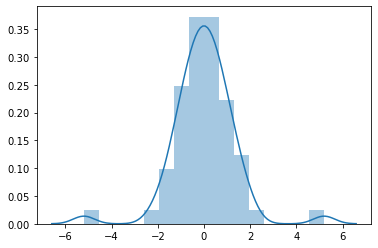

In [38]:
# plot post transformation ...
sns.distplot(x_features_quantrans[:,col_idx])

### Imputation

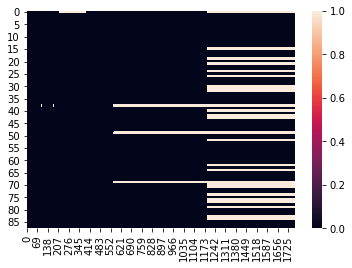

In [39]:
sns.heatmap(np.isnan(x_features_quantrans))

In [40]:
x_features_impute = pipeline2.named_steps['imp'].transform(x_features_quantrans)

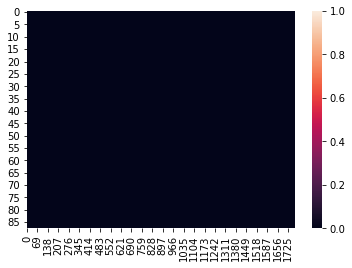

In [41]:
sns.heatmap(np.isnan(x_features_impute), vmin=0, vmax=1)

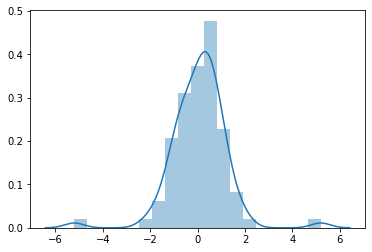

In [42]:
sns.distplot(x_features_impute[:,col_idx])

### Standardize

In [43]:
x_features_standard = pipeline2.named_steps['scaler'].transform(x_features_impute)

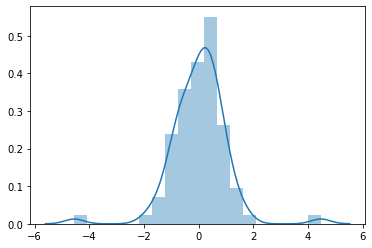

In [44]:
sns.distplot(x_features_standard[:,col_idx])

In [45]:
percent_diff = ((x_features_standard[:,col_idx] - x_features_impute[:,col_idx]) / x_features_impute[:,col_idx]) * 100

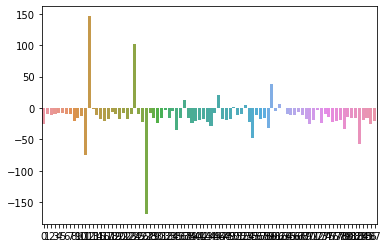

In [46]:
# changes in value for each participant as a result of standarizing
sns.barplot(x=np.arange(88), y=percent_diff)

### KBest (select 1000 most discriminating features)

In [47]:
best_1000_idx = pipeline2.named_steps['kbest'].get_support()
x_features_1000 = x_features_standard[:,best_1000_idx]
x_features_1000.shape

(88, 1000)

In [48]:
columns_1000 = x_features.columns[best_1000_idx]

In [49]:
modalities = ['allvol', 'alff', 't1r', 'dti', '31p']

modality_counts = {mod: [len(list(filter(lambda x: mod in x, columns_1000)))] for mod in modalities}
modality_counts

{'allvol': [71], 'alff': [59], 't1r': [121], 'dti': [282], '31p': [467]}

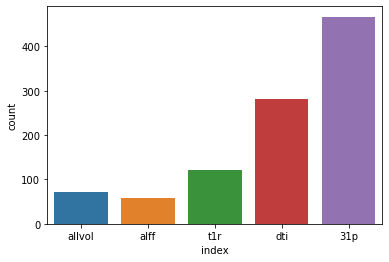

In [50]:
mod_df = pd.DataFrame.from_dict(modality_counts).T
mod_df.rename({0: 'count'}, axis=1, inplace=True)
sns.barplot(x='index', y='count', data=mod_df.reset_index())

### PCA

In [51]:
x_features_pca = pipeline2.named_steps['pca'].transform(x_features_1000)

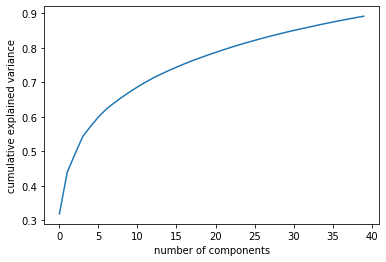

In [52]:
plt.plot(np.cumsum(pipeline2.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Recursive Feature Elimination (select 10 best PCA components)

In [53]:
pca_idx = pipeline2.named_steps['rfe'].get_support()
x_features_pca[:,pca_idx].shape

(88, 10)

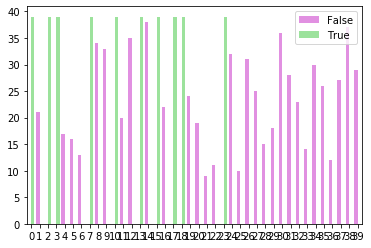

In [54]:
# look at which components were selected
colors = ['violet' if x else 'lightgreen' for x in pca_idx]
sns.barplot(x=np.arange(40), hue=pca_idx, y= 40 - pipeline2.named_steps['rfe'].ranking_, palette=colors)

In [55]:
x_features_best_pca = best_pca = x_features_pca[:,pca_idx]

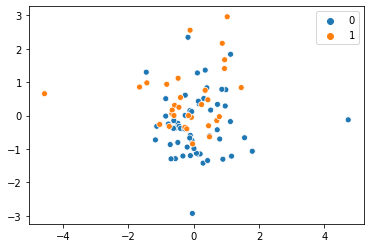

In [56]:
sns.scatterplot(x=best_pca[:,0], y=best_pca[:,1], hue=training_y)

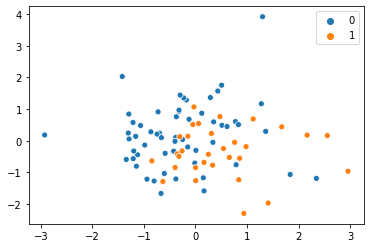

In [57]:
sns.scatterplot(x=best_pca[:,1], y=best_pca[:,2], hue=training_y)

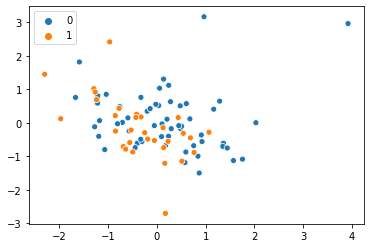

In [58]:
sns.scatterplot(x=best_pca[:,2], y=best_pca[:,3], hue=training_y)

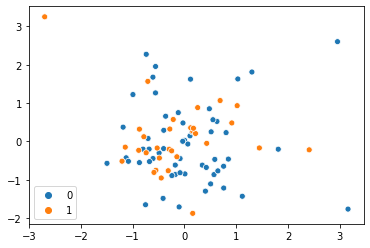

In [59]:
sns.scatterplot(x=best_pca[:,3], y=best_pca[:,4], hue=training_y)

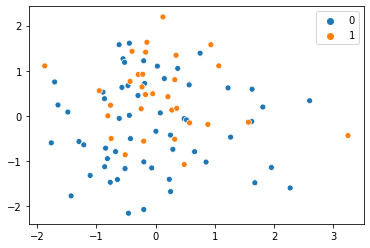

In [60]:
sns.scatterplot(x=best_pca[:,4], y=best_pca[:,5], hue=training_y)

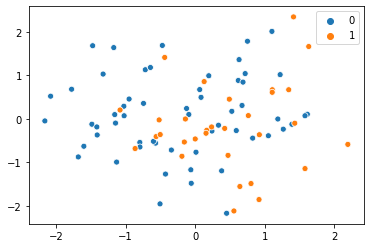

In [61]:
sns.scatterplot(x=best_pca[:,5], y=best_pca[:,6], hue=training_y)

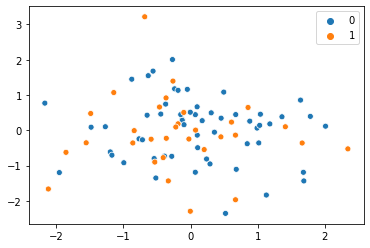

In [62]:
sns.scatterplot(x=best_pca[:,6], y=best_pca[:,7], hue=training_y)

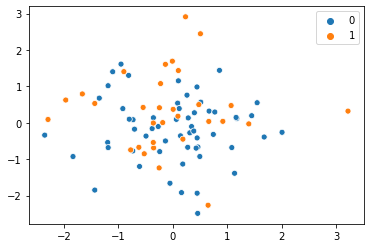

In [63]:
sns.scatterplot(x=best_pca[:,7], y=best_pca[:,8], hue=training_y)

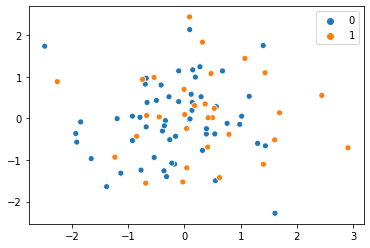

In [64]:
sns.scatterplot(x=best_pca[:,8], y=best_pca[:,9], hue=training_y)

In [65]:
loadings = pipeline2.named_steps['pca'].components_[pca_idx,:]

In [66]:
modality = [col.split('_')[0] for col in columns_1000]
loadings_df = pd.DataFrame(loadings.T)
loadings_df['modality'] = modality
loadings_df.rename({x: 'loading_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
loadings_df.head()

,loading_0,loading_1,loading_2,loading_3,loading_4,loading_5,loading_6,loading_7,loading_8,loading_9,modality
0,-0.000565,0.009236,0.005285,0.127032,0.041497,-0.052653,-0.041129,-0.007932,-0.067647,0.058649,allvol
1,0.005096,-0.027143,-0.055756,0.056170,0.013297,-0.074350,-0.016070,0.004038,0.027098,-0.005165,allvol
2,0.003139,-0.038489,-0.049576,-0.020939,0.045031,0.043714,0.063865,-0.052636,-0.016653,0.031076,allvol
3,0.004259,-0.012782,0.036731,0.071234,0.082245,0.011439,0.003867,0.016738,0.010569,0.023867,allvol
4,0.006163,-0.021923,-0.077503,0.002277,0.024508,0.044865,-0.048548,-0.012970,0.013502,0.050165,allvol


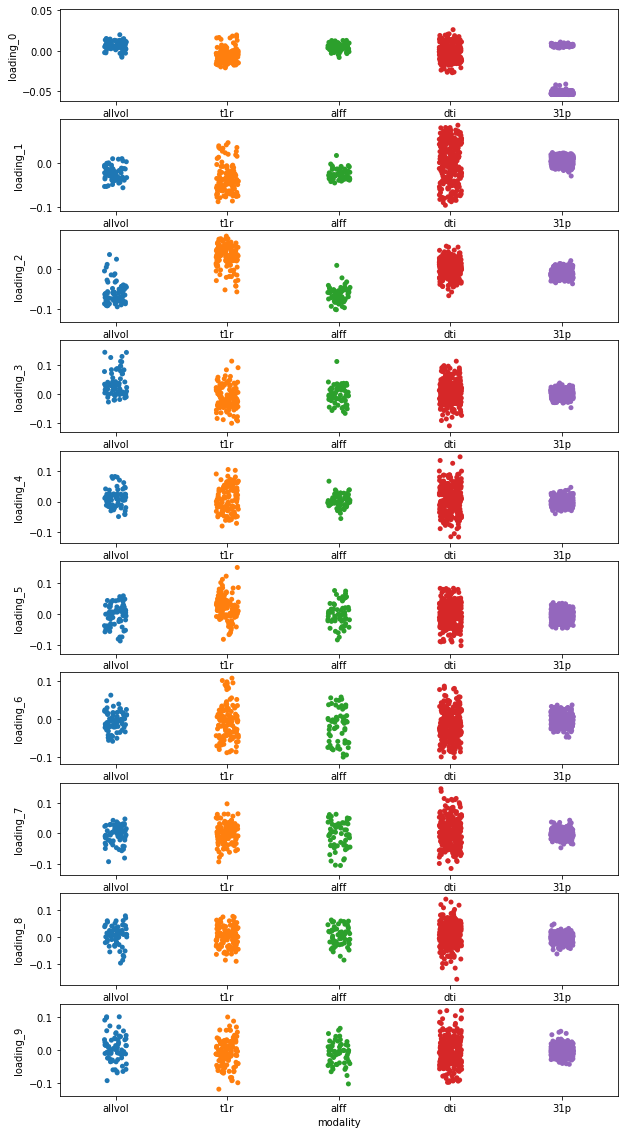

In [67]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

for (idx, ax) in enumerate(axes):
    sns.stripplot(x='modality', y='loading_{}'.format(idx), data=loadings_df.reset_index(), hue='modality', ax=ax)
    ax.get_legend().remove()

In [68]:
# lets look at loading 1, for spectroscopy
index = loadings_df.query("(modality == '31p') & (loading_0 < -0.054) ")['loading_0'].index
index.shape

(19,)

In [69]:
best_pca_features_df = pd.DataFrame(x_features_best_pca)
best_pca_features_df['group'] = training_y
best_pca_features_df.rename({x: 'pca_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
best_pca_features_df.head()


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,group
0,0.113016,1.277397,1.166303,0.404952,-1.294364,-0.570222,-0.558447,1.677769,-0.390368,-0.302782,0
1,0.965030,0.288530,1.364272,-0.607974,-0.443967,1.610240,0.105795,-0.494284,-0.364354,-1.261682,0
2,0.984092,0.776146,0.605303,0.570557,-0.863186,0.378997,-1.194846,-0.613327,-1.198339,-0.005698,0
3,1.128273,1.836820,-1.065090,-0.799724,-0.199965,-2.077913,0.520179,-2.356151,-0.338494,-0.054516,0
4,0.308797,0.513573,0.486826,-0.177623,-0.614976,-0.057544,-1.480613,0.087289,0.540324,-0.374218,0


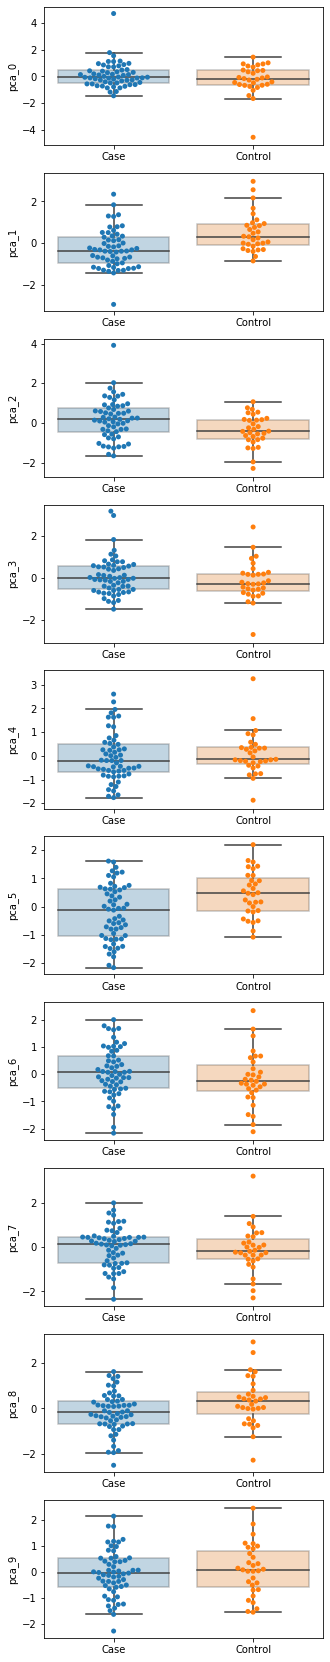

In [70]:
fig, axes = plt.subplots(nrows=10, figsize=(5, 30))

for idx, ax in enumerate(axes):
    sns.swarmplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df)
    sns.boxplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df,
                showfliers=False, dodge=False, boxprops=dict(alpha=.3))
    ax.get_legend().remove()
    ax.set_xticklabels(["Case", "Control"])
    ax.set_xlabel("")

In [71]:
list(columns_1000[index])

['31p_l_wm_supfront_aatp',
 '31p_r_precent_gatp',
 '31p_r_precent_aatp',
 '31p_r_smc_aatp',
 '31p_r_mfg_aatp',
 '31p_r_temppole_aatp',
 '31p_l_mfg_aatp',
 '31p_r_ocp_gatp',
 '31p_l_wm_suptemp_aatp',
 '31p_r_wm_postcent_aatp',
 '31p_r_crbl_cort_aatp',
 '31p_r_suppar_aatp',
 '31p_l_crblcrtx_gatp',
 '31p_l_wm_insula_aatp',
 '31p_r_postcent_gatp',
 '31p_r_wm_parcent_aatp',
 '31p_r_sfg_aatp',
 '31p_r_mog_aatp',
 '31p_r_wm_precent_aatp']

### Logistic Regression

In [72]:
from scipy.special import expit
pipeline2.named_steps['clf'].coef_

array([[-1.23483667,  2.53811006, -1.39940871, -1.41374364,  1.27034861,
         1.88076547, -0.98550745, -0.72363342,  0.75848958,  0.8082933 ]])

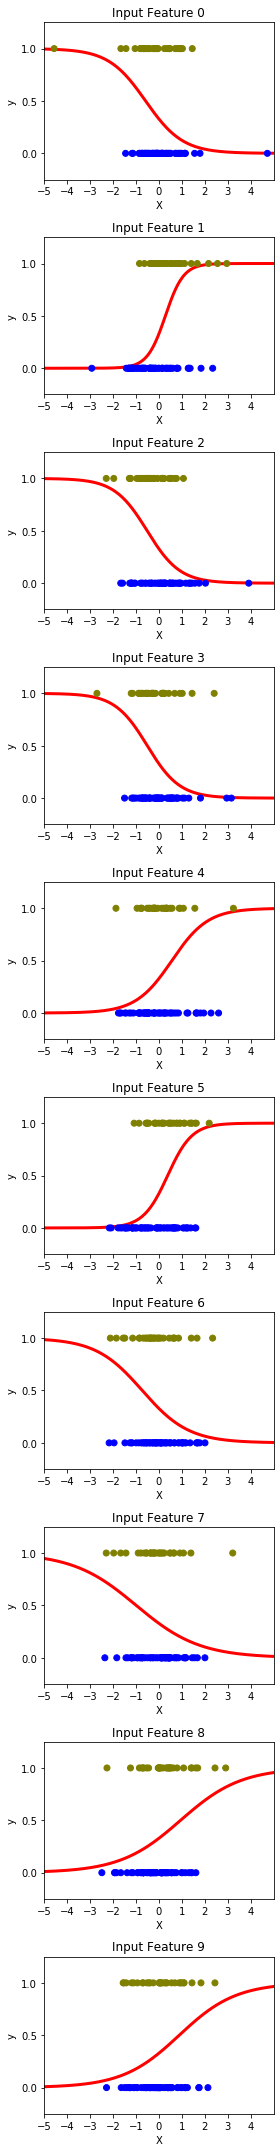

In [73]:
# and plot the result
colors = ['olive' if x == 1 else 'blue' for x in training_y]
fig, axes = plt.subplots(nrows=10, figsize=(4, 30))
for idx, ax in enumerate(axes):
    ax.scatter(x_features_best_pca[:,idx].ravel(), training_y, color=colors, zorder=20)
    X_test = np.linspace(-5, 5, 300)

    loss = expit(X_test * pipeline2.named_steps['clf'].coef_[0][idx] + pipeline2.named_steps['clf'].intercept_).ravel()
    ax.plot(X_test, loss, color='red', linewidth=3)


    ax.set_ylabel('y')
    ax.set_xlabel('X')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(-.25, 1.25)
    ax.set_xlim(-5, 5)
    ax.set_title("Input Feature {}".format(idx))

fig.tight_layout()

## See what the test data looks like

### Select Data

In [74]:
x_features = testing_X.loc[:,pipeline2.named_steps['data'].transformers_[0][2]]
x_features.shape

(39, 1770)

### Fix Outliers

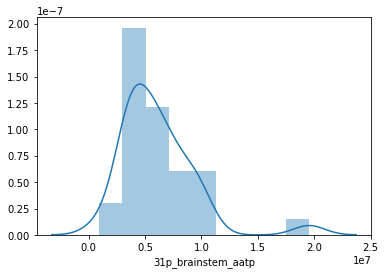

In [75]:
sns.distplot(x_features['31p_brainstem_aatp'])
col_idx = x_features.columns.get_loc('31p_brainstem_aatp')

In [76]:
x_features_quantrans = pipeline2.named_steps['outliers'].transform(x_features)

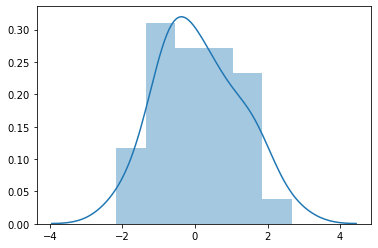

In [77]:
# plot post transformation ...
sns.distplot(x_features_quantrans[:,col_idx])

### Imputation

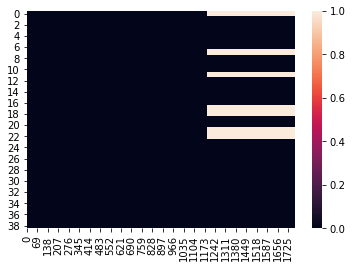

In [78]:
sns.heatmap(np.isnan(x_features_quantrans))

In [79]:
x_features_impute = pipeline2.named_steps['imp'].transform(x_features_quantrans)

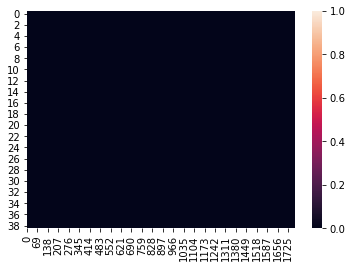

In [80]:
sns.heatmap(np.isnan(x_features_impute), vmin=0, vmax=1)

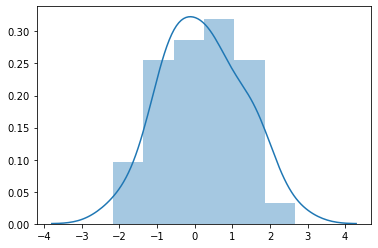

In [81]:
sns.distplot(x_features_impute[:,col_idx])

### Standardize

In [82]:
x_features_standard = pipeline2.named_steps['scaler'].transform(x_features_impute)

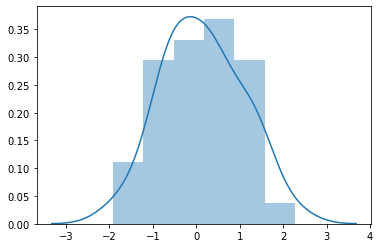

In [83]:
sns.distplot(x_features_standard[:,col_idx])

In [84]:
percent_diff = ((x_features_standard[:,col_idx] - x_features_impute[:,col_idx]) / x_features_impute[:,col_idx]) * 100

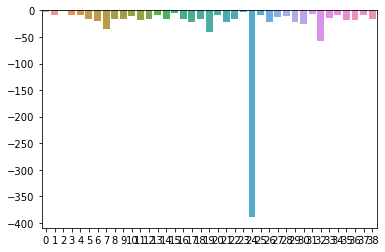

In [85]:
# changes in value for each participant as a result of standarizing
sns.barplot(x=np.arange(39), y=percent_diff)

### KBest (select 1000 most discriminating features)

In [86]:
best_1000_idx = pipeline2.named_steps['kbest'].get_support()
x_features_1000 = x_features_standard[:,best_1000_idx]
x_features_1000.shape

(39, 1000)

In [87]:
columns_1000 = x_features.columns[best_1000_idx]

In [88]:
modalities = ['allvol', 'alff', 't1r', 'dti', '31p']

modality_counts = {mod: [len(list(filter(lambda x: mod in x, columns_1000)))] for mod in modalities}
modality_counts

{'allvol': [71], 'alff': [59], 't1r': [121], 'dti': [282], '31p': [467]}

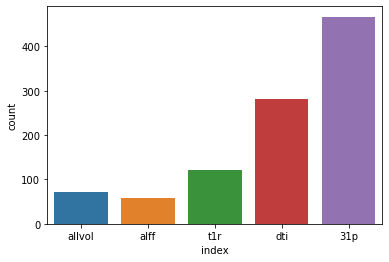

In [89]:
mod_df = pd.DataFrame.from_dict(modality_counts).T
mod_df.rename({0: 'count'}, axis=1, inplace=True)
sns.barplot(x='index', y='count', data=mod_df.reset_index())

### PCA

In [90]:
x_features_pca = pipeline2.named_steps['pca'].transform(x_features_1000)

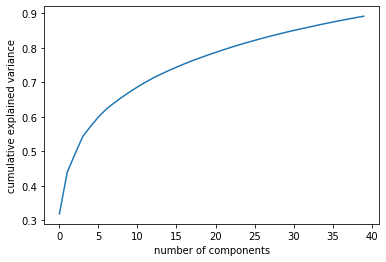

In [91]:
plt.plot(np.cumsum(pipeline2.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Recursive Feature Elimination (select 10 best PCA components)

In [92]:
pca_idx = pipeline2.named_steps['rfe'].get_support()
x_features_pca[:,pca_idx].shape

(39, 10)

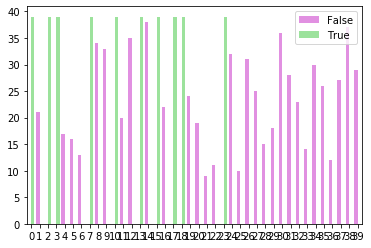

In [93]:
# look at which components were selected
colors = ['violet' if x else 'lightgreen' for x in pca_idx]
sns.barplot(x=np.arange(40), hue=pca_idx, y= 40 - pipeline2.named_steps['rfe'].ranking_, palette=colors)

In [94]:
x_features_best_pca = best_pca = x_features_pca[:,pca_idx]

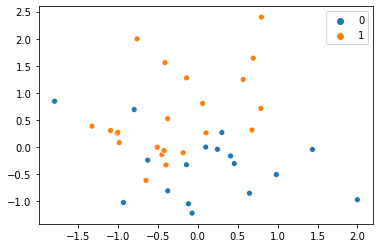

In [104]:
sns.scatterplot(x=best_pca[:,0], y=best_pca[:,1], hue=y_best_guess)

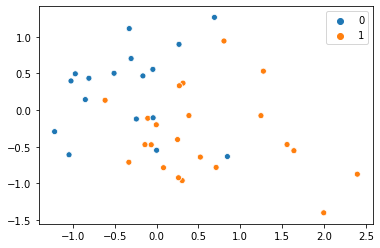

In [105]:
sns.scatterplot(x=best_pca[:,1], y=best_pca[:,2], hue=y_best_guess)

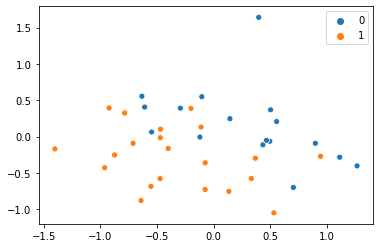

In [106]:
sns.scatterplot(x=best_pca[:,2], y=best_pca[:,3], hue=y_best_guess)

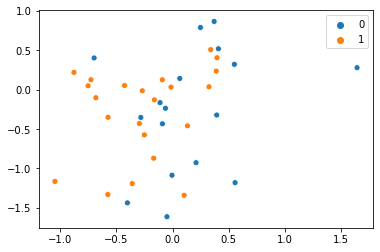

In [107]:
sns.scatterplot(x=best_pca[:,3], y=best_pca[:,4], hue=y_best_guess)

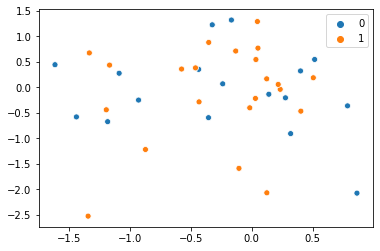

In [108]:
sns.scatterplot(x=best_pca[:,4], y=best_pca[:,5], hue=y_best_guess)

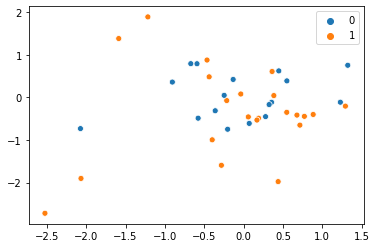

In [109]:
sns.scatterplot(x=best_pca[:,5], y=best_pca[:,6], hue=y_best_guess)

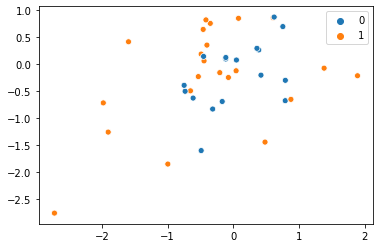

In [110]:
sns.scatterplot(x=best_pca[:,6], y=best_pca[:,7], hue=y_best_guess)

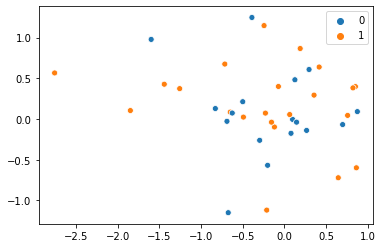

In [111]:
sns.scatterplot(x=best_pca[:,7], y=best_pca[:,8], hue=y_best_guess)

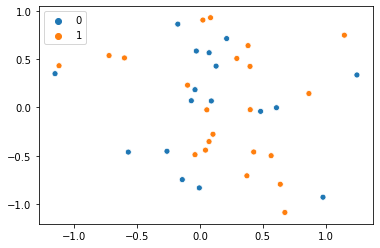

In [112]:
sns.scatterplot(x=best_pca[:,8], y=best_pca[:,9], hue=y_best_guess)

In [113]:
loadings = pipeline2.named_steps['pca'].components_[pca_idx,:]

In [114]:
modality = [col.split('_')[0] for col in columns_1000]
loadings_df = pd.DataFrame(loadings.T)
loadings_df['modality'] = modality
loadings_df.rename({x: 'loading_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
loadings_df.head()

,loading_0,loading_1,loading_2,loading_3,loading_4,loading_5,loading_6,loading_7,loading_8,loading_9,modality
0,-0.000565,0.009236,0.005285,0.127032,0.041497,-0.052653,-0.041129,-0.007932,-0.067647,0.058649,allvol
1,0.005096,-0.027143,-0.055756,0.056170,0.013297,-0.074350,-0.016070,0.004038,0.027098,-0.005165,allvol
2,0.003139,-0.038489,-0.049576,-0.020939,0.045031,0.043714,0.063865,-0.052636,-0.016653,0.031076,allvol
3,0.004259,-0.012782,0.036731,0.071234,0.082245,0.011439,0.003867,0.016738,0.010569,0.023867,allvol
4,0.006163,-0.021923,-0.077503,0.002277,0.024508,0.044865,-0.048548,-0.012970,0.013502,0.050165,allvol


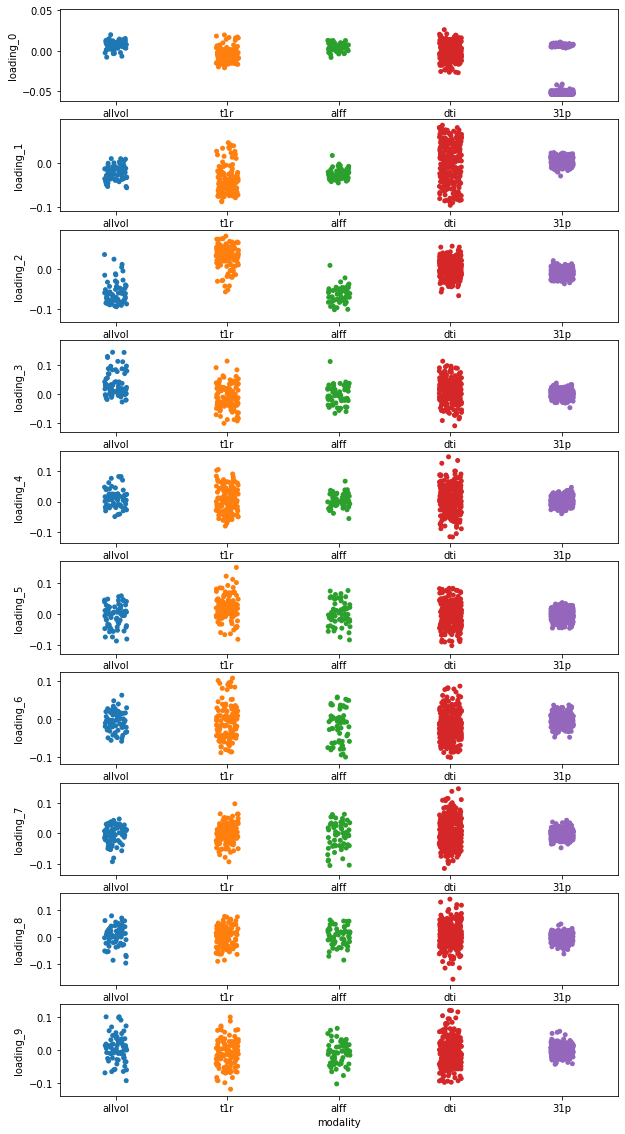

In [115]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

for (idx, ax) in enumerate(axes):
    sns.stripplot(x='modality', y='loading_{}'.format(idx), data=loadings_df.reset_index(), hue='modality', ax=ax)
    ax.get_legend().remove()

In [116]:
# lets look at loading 1, for spectroscopy
index = loadings_df.query("(modality == '31p') & (loading_0 < -0.054) ")['loading_0'].index
index.shape

(19,)

In [117]:
best_pca_features_df = pd.DataFrame(x_features_best_pca)
best_pca_features_df['group'] = y_best_guess
best_pca_features_df.rename({x: 'pca_{}'.format(x) for x in range(10)}, axis=1, inplace=True)
best_pca_features_df.head()


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,group
0,0.302616,0.268787,0.896001,-0.090862,-0.434535,0.355021,-0.116794,0.099436,-0.004703,-0.833963,0
1,0.569064,1.247597,-0.076487,-0.726314,0.124063,-2.066136,-1.903654,-1.255065,0.373393,-0.708503,1
2,0.694974,1.641353,-0.554414,-0.682710,-0.104327,-1.586529,1.379384,-0.070878,0.399888,-0.023469,1
3,0.790756,0.712022,-0.782760,0.338563,0.504905,0.190197,-0.490151,0.190236,0.866475,0.143899,1
4,0.679804,0.316213,0.366728,-0.295992,-0.431443,-0.282439,-1.594913,0.418151,0.638853,-0.796052,1


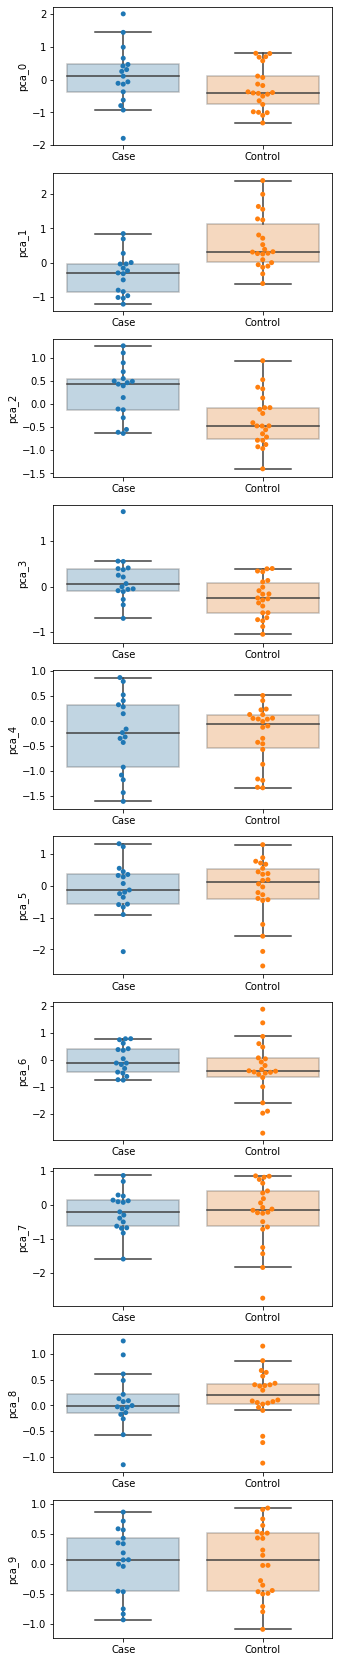

In [118]:
fig, axes = plt.subplots(nrows=10, figsize=(5, 30))

for idx, ax in enumerate(axes):
    sns.swarmplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df)
    sns.boxplot(x='group', y='pca_{}'.format(idx), hue='group', ax=ax, data=best_pca_features_df,
                showfliers=False, dodge=False, boxprops=dict(alpha=.3))
    ax.get_legend().remove()
    ax.set_xticklabels(["Case", "Control"])
    ax.set_xlabel("")

In [119]:
list(columns_1000[index])

['31p_l_wm_supfront_aatp',
 '31p_r_precent_gatp',
 '31p_r_precent_aatp',
 '31p_r_smc_aatp',
 '31p_r_mfg_aatp',
 '31p_r_temppole_aatp',
 '31p_l_mfg_aatp',
 '31p_r_ocp_gatp',
 '31p_l_wm_suptemp_aatp',
 '31p_r_wm_postcent_aatp',
 '31p_r_crbl_cort_aatp',
 '31p_r_suppar_aatp',
 '31p_l_crblcrtx_gatp',
 '31p_l_wm_insula_aatp',
 '31p_r_postcent_gatp',
 '31p_r_wm_parcent_aatp',
 '31p_r_sfg_aatp',
 '31p_r_mog_aatp',
 '31p_r_wm_precent_aatp']

### Logistic Regression

In [120]:
from scipy.special import expit
pipeline2.named_steps['clf'].coef_

array([[-1.23483667,  2.53811006, -1.39940871, -1.41374364,  1.27034861,
         1.88076547, -0.98550745, -0.72363342,  0.75848958,  0.8082933 ]])

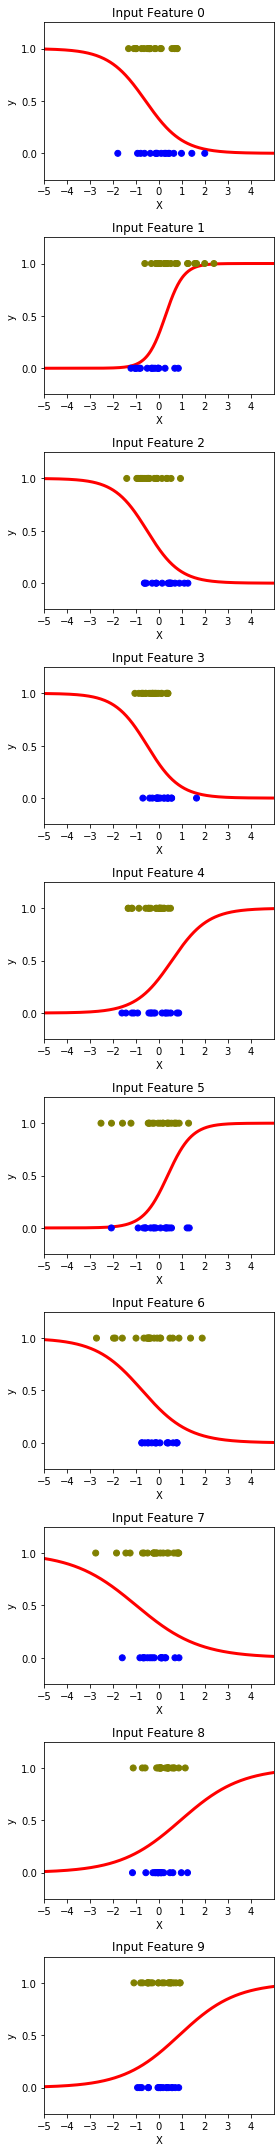

In [121]:
# and plot the result
colors = ['olive' if x == 1 else 'blue' for x in y_best_guess]
fig, axes = plt.subplots(nrows=10, figsize=(4, 30))
for idx, ax in enumerate(axes):
    ax.scatter(x_features_best_pca[:,idx].ravel(), y_best_guess, color=colors, zorder=20)
    X_test = np.linspace(-5, 5, 300)

    loss = expit(X_test * pipeline2.named_steps['clf'].coef_[0][idx] + pipeline2.named_steps['clf'].intercept_).ravel()
    ax.plot(X_test, loss, color='red', linewidth=3)


    ax.set_ylabel('y')
    ax.set_xlabel('X')
    ax.set_xticks(range(-5, 5))
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim(-.25, 1.25)
    ax.set_xlim(-5, 5)
    ax.set_title("Input Feature {}".format(idx))

fig.tight_layout()